In [63]:
import os
import pandas as pd
import git
import matplotlib.pyplot as plt
folder = "../../data/format-corpus"
relative_path = '../../data/format-corpus'
repo = git.Git(folder)

In [64]:
import folderstats

df = folderstats.folderstats(folder, ignore_hidden=True,hash_name="sha256")
df = df[df.folder==False]
df

,id,path,name,extension,size,atime,mtime,ctime,folder,num_files,depth,parent,uid,sha256
0,4,../../data/format-corpus\desktop-publishing\In...,Neddy_Flyer_ft_HeatherRyan,jpg,1620612,2022-03-24 09:29:09,2022-03-22 11:00:24,2022-03-22 11:00:24,False,NaN,2,3,0,9d89cc0347adeb5141e4feea3d411b0fd2252c63145e1c...
1,5,../../data/format-corpus\desktop-publishing\In...,Neddy_Flyer_HeatherRyan,indd,1503232,2022-03-24 09:29:09,2022-03-22 11:00:24,2022-03-22 11:00:24,False,NaN,2,3,0,8f206d618c0161cfddf4c18aa3932ed99d9e500bf1260c...
2,6,../../data/format-corpus\desktop-publishing\In...,Neddy_Flyer_HeatherRyan,pdf,59106,2022-03-24 09:29:09,2022-03-22 11:00:24,2022-03-22 11:00:24,False,NaN,2,3,0,6a3c9444d4905c8896a717be7c30ee7d20b3c319eb2d3d...
3,7,../../data/format-corpus\desktop-publishing\In...,Neddy_Flyer_README_HeatherRyan.md,rtf,1232,2022-03-24 09:29:09,2022-03-22 11:00:24,2022-03-22 11:00:24,False,NaN,2,3,0,3ef3b90e7bf9e863d1ae9f862eaa5e1cd87e8f9ef67438...
6,11,../../data/format-corpus\disk-images\fat12\opf...,blank-untitled-volume,img,1474560,2022-03-24 09:29:10,2022-03-22 11:00:24,2022-03-22 11:00:24,False,NaN,3,10,0,039713487932afa67bd3c024e4d6284aac5548092d8b9b...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755,1759,../../data/format-corpus\video\Quicktime\xdcam...,xdcam-hd422-720p24,mov,6518304,2022-03-24 09:29:10,2022-03-22 11:00:27,2022-03-22 11:00:27,False,NaN,2,1701,0,82f1477829488ed45f688744dc1a2cac111468b21158d2...
1756,1760,../../data/format-corpus\video\Quicktime\xdcam...,xdcam-hd422-720p25,mov,6251203,2022-03-24 09:29:10,2022-03-22 11:00:27,2022-03-22 11:00:27,False,NaN,2,1701,0,2a064a262bfa7377803185db0331b15f77d2a7dce98043...
1757,1761,../../data/format-corpus\video\Quicktime\xdcam...,xdcam-hd422-720p30,mov,5215055,2022-03-24 09:29:10,2022-03-22 11:00:27,2022-03-22 11:00:27,False,NaN,2,1701,0,718a57ef016c80e0d75b08ba595b51961d1013173e5902...
1758,1762,../../data/format-corpus\video\Quicktime\xdcam...,xdcam-hd422-720p50,mov,3125967,2022-03-24 09:29:10,2022-03-22 11:00:27,2022-03-22 11:00:27,False,NaN,2,1701,0,69405cbb8cfded9d6244eff13955564e8c5ad54fe1c745...


<AxesSubplot:>

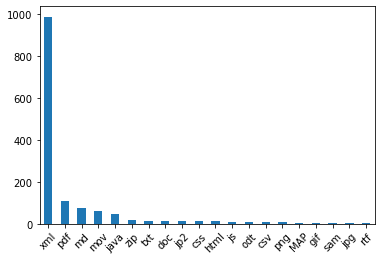

In [65]:
df.extension.value_counts()[:20].plot.bar(rot=45)

In [66]:
df.extension.value_counts()

xml      986
pdf      106
md        74
mov       61
java      47
        ... 
sha1       1
123        1
opml       1
nmind      1
rft        1
Name: extension, Length: 90, dtype: int64

In [67]:
df.loc[df["extension"]=="pdf"]

,id,path,name,extension,size,atime,mtime,ctime,folder,num_files,depth,parent,uid,sha256
2,6,../../data/format-corpus\desktop-publishing\In...,Neddy_Flyer_HeatherRyan,pdf,59106,2022-03-24 09:29:09,2022-03-22 11:00:24,2022-03-22 11:00:24,False,NaN,2,3,0,6a3c9444d4905c8896a717be7c30ee7d20b3c319eb2d3d...
43,47,../../data/format-corpus\ebooks\calibre 0.8.57...,Lorem Ipsum - Andrew Jackson,pdf,41814,2022-03-24 09:29:10,2022-03-22 11:00:24,2022-03-22 11:00:24,False,NaN,2,37,0,de27b8feda2ab31df801c4894732389a5255f39a1c6a97...
61,65,../../data/format-corpus\ebooks\calibre 0.9.0\...,lorem-ipsum,pdf,43433,2022-03-24 09:29:10,2022-03-22 11:00:24,2022-03-22 11:00:24,False,NaN,2,55,0,ed5f14efaada2cb0eb76cc3529e08859667b2319adb38c...
71,75,../../data/format-corpus\ebooks\iBooks Author ...,lorem-ipsum-openprintcopypw,pdf,32582,2022-03-24 09:29:10,2022-03-22 11:00:24,2022-03-22 11:00:24,False,NaN,2,74,0,964ef0fed1d9757e6b06f6197503b3e06223435d1a943e...
72,76,../../data/format-corpus\ebooks\iBooks Author ...,lorem-ipsum-plus-image-openprintcopypw,pdf,66644,2022-03-24 09:29:10,2022-03-22 11:00:24,2022-03-22 11:00:24,False,NaN,2,74,0,5133a751297b9bff66cff73caa9bf26b29859bc6e13f6d...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,1570,../../data/format-corpus\tools\fidget\src\test...,999999,pdf,9400,2022-03-24 09:29:10,2022-03-22 11:00:26,2022-03-22 11:00:26,False,NaN,11,1566,0,2607e41c9ce385785c7768085ad181a6db858bbfa9c1a2...
1655,1661,../../data/format-corpus\variations\variations...,lorem-ipsum-pages-09-4.1-923,pdf,23142,2022-03-24 09:29:10,2022-03-22 11:00:26,2022-03-22 11:00:26,False,NaN,4,1660,0,3679a9b9af012f0c353825737252991a052376a502571d...
1657,1663,../../data/format-corpus\variations\variations...,lorem-ipsum.oo3.2.export-pdfa,pdf,36972,2022-03-24 09:29:10,2022-03-22 11:00:26,2022-03-22 11:00:26,False,NaN,4,1660,0,2df43480ffc930cd0ab78227df923d2390bcd1b42c602b...
1658,1664,../../data/format-corpus\variations\variations...,lorem-ipsum.oo3.2.export,pdf,27489,2022-03-24 09:29:10,2022-03-22 11:00:26,2022-03-22 11:00:26,False,NaN,4,1660,0,426f7e1d1156e50b53512e58289dd83730b700019c2f5e...


In [68]:
df["p"]=0.001
metadata = df.copy()
metadata["p"]=0.8
metadata["name"]=metadata["name"]+".meta"
metadata["extension"]= "metadata"
df = pd.concat([df,metadata],ignore_index=True)
df["name"].value_counts()

readme                                    36
readme.meta                               36
lorem-ipsum.meta                          27
lorem-ipsum                               27
Lorem Ipsum - Andrew Jackson.meta         17
                                          ..
audio_historicaldates.meta                 1
animatedgifs_historicaldates.meta          1
JW_disk9_hfstest_9.meta                    1
Neddy_Flyer_README_HeatherRyan.md.meta     1
xdcam-hd422-720p60.meta                    1
Name: name, Length: 1884, dtype: int64

In [69]:
df["p"]

0       0.001
1       0.001
2       0.001
3       0.001
4       0.001
        ...  
3115    0.800
3116    0.800
3117    0.800
3118    0.800
3119    0.800
Name: p, Length: 3120, dtype: float64

In [70]:
s1 = df["extension"].value_counts().rename("N")
s2 = df.groupby(["extension"])["p"].mean()
df_ = pd.concat([s1, s2], axis=1)
df_

,N,p
metadata,1560,0.800
xml,986,0.001
pdf,106,0.001
md,74,0.001
mov,61,0.001
...,...,...
sha1,1,0.001
qpw,1,0.001
123,1,0.001
opml,1,0.001


In [71]:
import numpy as np
import math

def expected_operations(N,k,p):
    if(k==0.0):
        k=N
    number_of_pools = np.ceil(N/k)
    number_of_positive_pools = (1 - np.power((1-p),k)) * number_of_pools
    return np.ceil(number_of_pools + number_of_positive_pools*k)

def expected_writes(N,k,p):
    if(k==0.0):
        k=N
    number_of_pools = np.ceil(N/k)
    return number_of_pools

def expected_scrubbing(N,k,p):
    if(k==0.0):
        k=N
    number_of_pools = np.ceil(N/k)
    number_of_positive_pools = (1 - np.power((1-p),k))* number_of_pools
    return np.ceil(number_of_positive_pools*k)

def optimal_pool_size(N,p):
    if(p<=0.0):
        return N
    return np.ceil(1.24*np.power(p,-0.466))

df_["k"] = df_.apply(lambda row: optimal_pool_size(row.N,row.p),axis=1)
df_["operations"] = df_.apply(lambda row: expected_operations(row.N,row.k,row.p),axis=1)
df_["operations_naive"] = df_.apply(lambda row: expected_operations(row.N,1,row.p),axis=1)
df_["efficiency"] = df_.apply(lambda row: row.operations_naive/row.operations,axis=1)
df_["writes"] = df_.apply(lambda row: expected_writes(row.N,row.k,row.p),axis=1)
df_["scrubbing"] = df_.apply(lambda row: expected_scrubbing(row.N,row.k,row.p),axis=1)
df_["net_operations_per_object"] = df_.apply(lambda row: row.operations/row.N,axis=1)
df_["net_operations_per_object_naive"] = df_.apply(lambda row: row.operations_naive/row.N,axis=1)
df_

,N,p,k,operations,operations_naive,efficiency,writes,scrubbing,net_operations_per_object,net_operations_per_object_naive
metadata,1560,0.800,2.0,2278.0,2808.0,1.232660,780.0,1498.0,1.460256,1.800000
xml,986,0.001,32.0,63.0,987.0,15.666667,31.0,32.0,0.063895,1.001014
pdf,106,0.001,32.0,9.0,107.0,11.888889,4.0,5.0,0.084906,1.009434
md,74,0.001,32.0,7.0,75.0,10.714286,3.0,4.0,0.094595,1.013514
mov,61,0.001,32.0,5.0,62.0,12.400000,2.0,3.0,0.081967,1.016393
...,...,...,...,...,...,...,...,...,...,...
sha1,1,0.001,32.0,3.0,2.0,0.666667,1.0,2.0,3.000000,2.000000
qpw,1,0.001,32.0,3.0,2.0,0.666667,1.0,2.0,3.000000,2.000000
123,1,0.001,32.0,3.0,2.0,0.666667,1.0,2.0,3.000000,2.000000
opml,1,0.001,32.0,3.0,2.0,0.666667,1.0,2.0,3.000000,2.000000


In [76]:
df_["operations"].sum()

2622.0

In [77]:
df_["operations_naive"].sum()

4432.0

In [73]:
df_["net_operations_per_object_naive"].mean()

1.5941155380373488

In [74]:
df_["net_operations_per_object"].mean()

1.7747323969868634

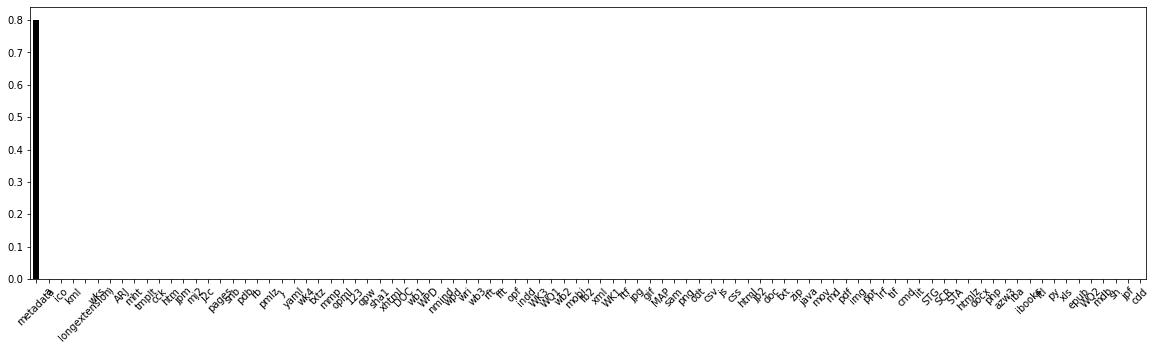

In [75]:
df_.sort_values(by=["p"],ascending=False)["p"].plot.bar(rot=45,figsize=(20, 5),color="black")
df_["p"].value_counts()
plt.xticks(fontsize=10)
plt.show()